<font color = 'red' size='+5'><b> LSTM </b></font>

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
import textwrap
import re


import string
import nltk
from nltk.corpus import stopwords


from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Dropout, Activation, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

<font color = 'purple' size='+4'><b>1. Dataset</b></font>

In [3]:
os.chdir('/Users/maguetteguenongom/Documents/')

In [4]:
movie_reviews = pd.read_csv('train.csv', sep = 'delimiter', names = ['text'], skiprows=1)

# Separating IDs and labels from reviews
movie_reviews[['id', 'label', 'review']] = movie_reviews.text.str.split(",", n=2, expand = True)


# Drop unnecessary columns
movie_reviews = movie_reviews [['label', 'review']]
movie_reviews.head()

,label,review
0,1,Wizards of the Lost Kingdom is a movie about a...
1,1,Brilliant adaptation of the largely interior m...
2,1,Typical De Palma movie made with lot's of styl...
3,1,This is a fantastic series first and foremost....
4,1,My only minor quibble with the film I grew up ...


In [5]:
movie_reviews['label'] = movie_reviews['label'].astype(int)

Text(0, 0.5, 'Frequency')

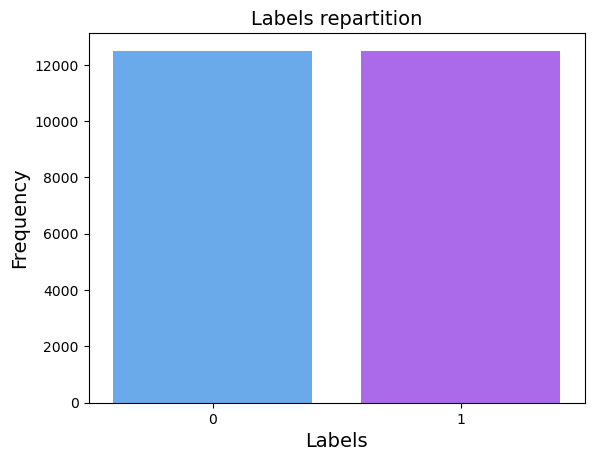

In [6]:
palette = 'cool'
sns.set_palette(palette)
sns.countplot(data = movie_reviews, x = 'label', palette = palette)
plt.title("Labels repartition", fontsize = 14)
plt.xlabel('Labels', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

<font color = 'magenta' size='+3'><b>1.2. Reviews</b></font>

In [7]:
def clean_review(review):
    # Remove HTML tags
    cleanr = re.compile('<.*?>')
    review = re.sub(cleanr, '', review)

    # Remove signatures (e.g., "Name email date")
    review = re.sub(r'\b\w+@\w+\.\w+\b', '', review)  # Remove email addresses
    review = re.sub(r'\b\d{1,2} (?:January|February|March|April|May|June|July|August|September|October|November|December) \d{4}\b', '', review)  # Remove dates (e.g., "15 June 2008")

    return review.strip()


movie_reviews['review'] = movie_reviews['review'].apply(clean_review)


wrapper = textwrap.TextWrapper(width=80)

# Code for underlining
underline_start = '\033[4m'
underline_end = '\033[0m'


# Print the first n reviews
n = 10
for i, review in enumerate(movie_reviews['review'].head(n)):
    header = f"Review {i+1}:"
    wrapped_review = wrapper.fill(review)
    print(f"{underline_start}{header}{underline_end}\n{wrapped_review}\n")

Review 1:
Wizards of the Lost Kingdom is a movie about a young prince (Simon) who is
banished from his kingdom due to his father (the king) being killed by the
cliche "evil adviser". This movie's about Simon's adventures. The special
effects, plot, acting, and generally everything about this movie is BAD.
However, it's so bad that it's funny. You will keep watching this movie simply
because it's so bad it's funny, and, like the other reviewer of the movie said,
it's so bad it's good.

Review 2:
Brilliant adaptation of the largely interior monologues of Leopold Bloom,
Stephen Dedalus, and Molly Bloom by Joseph Strick in recreating the endearing
portrait of Dublin on June 16, 1904 - Bloomsday - a day to be celebrated -
double entendre intended! Bravo director Strick, screenwriter Haines, as well as
casting director and cinematographer in creating this masterpiece. Gunter Grass'
novel, The Tin Drum filmed by Volker Schlöndorff (1979)is another fine film
adaptation of interior monologue wh

In [9]:
# Lengths of reviews
review_lengths = movie_reviews['review'].apply(lambda x: len(x.split()))

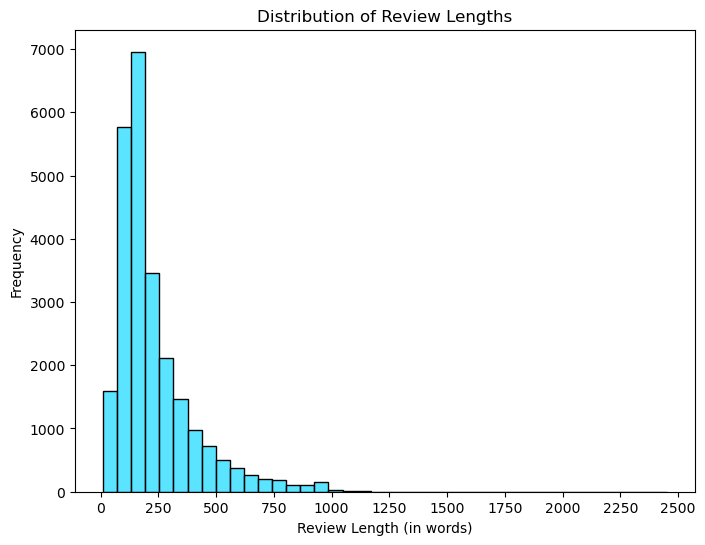

In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(review_lengths, bins = 40, kde = False, palette = palette, edgecolor='black')
plt.xlabel('Review Length (in words)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
max_length = review_lengths.max()
bin_edges = np.arange(0, max_length + 250, 250)
plt.xticks(bin_edges)

plt.show()

<font color = 'purple' size='+4'><b>2. Preprocessing</b></font>

In [11]:
max_seq_length = 225

In [12]:
# This function below removes all stopwords except 'not'
def remove_stopword(text):
    stopword = stopwords.words('english')
    stopword.remove('not')
    a=[w for w in nltk.word_tokenize(text) if w not in stopword]
    return ' '.join(a)

In [13]:
# Removing stopwords (except not)
movie_reviews['clean_review'] = movie_reviews['review'].apply(remove_stopword)

In [14]:
seq = movie_reviews['clean_review'].tolist()

In [15]:
tokenizer = Tokenizer(num_words = None,
                      filters='"#$%&()*+-/<=>@[\]^_`{|}~',
                      lower = False)

tokenizer.fit_on_texts(seq)

sequences = tokenizer.texts_to_sequences(seq)

padded_sequences = pad_sequences(sequences, maxlen = max_seq_length, padding='post', truncating='post')

In [16]:
movie_reviews['padded_sequences'] = list(padded_sequences)
movie_reviews

,label,review,clean_review,padded_sequences
0,1,Wizards of the Lost Kingdom is a movie about a...,Wizards Lost Kingdom movie young prince ( Simo...,"[15004, 2277, 7921, 5, 114, 5760, 1833, 18247,..."
1,1,Brilliant adaptation of the largely interior m...,Brilliant adaptation largely interior monologu...,"[6161, 1162, 2157, 7923, 9234, 10239, 7232, 1,..."
2,1,Typical De Palma movie made with lot's of styl...,Typical De Palma movie made lot 's style scene...,"[15556, 1383, 4080, 5, 34, 92, 4, 311, 66, 4, ..."
3,1,This is a fantastic series first and foremost....,This fantastic series first foremost . It well...,"[18, 720, 117, 35, 7924, 2, 14, 30, 140, 137, ..."
4,1,My only minor quibble with the film I grew up ...,My minor quibble film I grew knowing STAIRWAY ...,"[258, 1369, 14484, 6, 3, 1965, 1261, 61062, 28..."
...,...,...,...,...
24995,0,I hate to even waste the time it takes to writ...,I hate even waste time takes write 10 lines at...,"[3, 706, 23, 344, 19, 208, 796, 86, 322, 9010,..."
24996,0,The whole Biker Movie genre has to be made up ...,The whole Biker Movie genre made worst films e...,"[7, 133, 31023, 1047, 417, 34, 173, 44, 61, 34..."
24997,0,This movie was horrible. I watched it three ti...,"This movie horrible . I watched three times , ...","[18, 5, 465, 2, 3, 204, 223, 138, 1, 10, 23, 1..."
24998,0,"That's not the sound of bees, that's the effec...","That 's not sound bees , 's effect induced wat...","[174, 4, 10, 405, 21185, 1, 4, 863, 9736, 82, ..."


In [17]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, movie_reviews.label,
                                                    test_size=0.20,  random_state=1234, shuffle = True)

In [18]:
idx_word = tokenizer.index_word
num_words = len(idx_word) + 1
num_words

130351

<font color = 'purple' size='+4'><b>3. LSTM </b></font>

In [19]:
embedding_dim = 300
epochs = 10
batch_size = 64
lr = 0.001

<font color = 'magenta' size='+2'><b>3.1. Learning rate = 0.001, epochs = 10, embedding_dim = 300, batch_size = 64</b></font>

In [20]:
lstm1 = Sequential()
lstm1.add(Embedding(num_words, embedding_dim, input_length=max_seq_length))
lstm1.add(LSTM(units=256, return_sequences=True))
lstm1.add(LSTM(units=128))
lstm1.add(Dropout(0.2))
lstm1.add(Dense(1, activation='sigmoid'))

2024-06-21 21:04:59.902574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
optimizer_lstm1 = Adam(learning_rate = lr)
lstm1.compile(optimizer = optimizer_lstm1, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
his_lstm1 = lstm1.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 623s 2s/step - loss: 0.6937 - accuracy: 0.5069 - val_loss: 0.6927 - val_accuracy: 0.5013
Epoch 2/10
250/250 [==============================] - 606s 2s/step - loss: 0.6791 - accuracy: 0.5509 - val_loss: 0.6921 - val_accuracy: 0.5203
Epoch 3/10
250/250 [==============================] - 601s 2s/step - loss: 0.5958 - accuracy: 0.6211 - val_loss: 0.6189 - val_accuracy: 0.7452
Epoch 4/10
250/250 [==============================] - 601s 2s/step - loss: 0.5065 - accuracy: 0.7388 - val_loss: 0.6377 - val_accuracy: 0.7548
Epoch 5/10
250/250 [==============================] - 616s 2s/step - loss: 0.4019 - accuracy: 0.8386 - val_loss: 0.5093 - val_accuracy: 0.8115
Epoch 6/10
250/250 [==============================] - 620s 2s/step - loss: 0.3024 - accuracy: 0.8869 - val_loss: 0.4754 - val_accuracy: 0.8005
Epoch 7/10
250/250 [==============================] - 624s 2s/step - loss: 0.2497 - accuracy: 0.9020 - val_loss: 0.6361 - val_accuracy: 0.7850

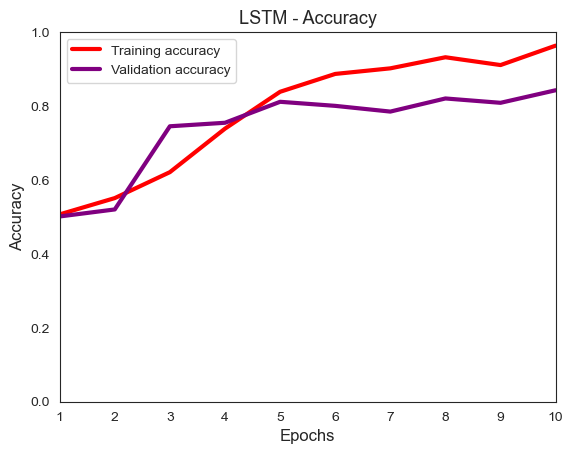

In [23]:
# Accuracy
sns.set_style('white')
sns.lineplot(x=range(1, len(his_lstm1.history['accuracy']) + 1), y = his_lstm1.history['accuracy'],
             label='Training accuracy', linewidth=3, color = 'red')
sns.lineplot(x=range(1, len(his_lstm1.history['val_accuracy']) + 1), y = his_lstm1.history['val_accuracy'],
             label='Validation accuracy', linewidth=3, color = 'purple')
plt.title("LSTM - Accuracy", fontsize=13)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.xlim(1, len(his_lstm1.history['accuracy']))
plt.ylim(0, 1)
plt.legend()
plt.show()

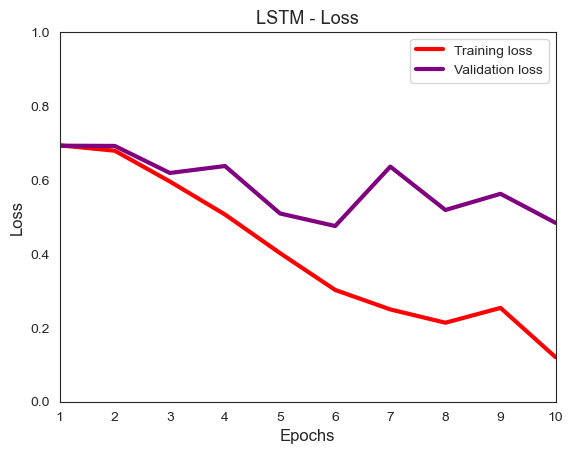

In [24]:
# Loss
sns.set_style('white')
sns.lineplot(x=range(1, len(his_lstm1.history['loss']) + 1), y = his_lstm1.history['loss'],
             label='Training loss', linewidth=3, color = 'red')
sns.lineplot(x=range(1, len(his_lstm1.history['val_loss']) + 1), y = his_lstm1.history['val_loss'],
             label='Validation loss', linewidth=3, color = 'purple')
plt.title("LSTM - Loss", fontsize=13)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.xlim(1, len(his_lstm1.history['loss']))
plt.ylim(0, 1)
plt.legend()
plt.show()

In [25]:
# Test performance
loss_lstm1, accuracy_lstm1 = lstm1.evaluate(X_test, y_test)
print(f'LSTM - Test Accuracy: {accuracy_lstm1:.4f}')

157/157 [==============================] - 50s 321ms/step - loss: 0.4790 - accuracy: 0.8446
LSTM - Test Accuracy: 0.8446


In [26]:
y_hat_test_lstm1 = lstm1.predict(X_test)
y_hat_test_lstm1 = (y_hat_test_lstm1 > 0.5).astype(int)

157/157 [==============================] - 52s 325ms/step


In [27]:
from sklearn import metrics

In [28]:
# Confusion matrix - test set
conf_mat_test = metrics.confusion_matrix(y_test, y_hat_test_lstm1)

Text(0.5, 269.55555555555554, 'Predicted labels')

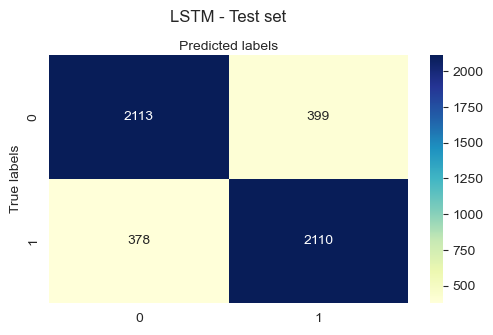

In [29]:
class_names=[0,1]
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Heatmap
sns.heatmap(pd.DataFrame(conf_mat_test), annot = True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('LSTM - Test set', y=1.1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [30]:
fpr_test = conf_mat_test[0,1] / (conf_mat_test[0,0] + conf_mat_test[0,1])
fnr_test = conf_mat_test[1,0] / (conf_mat_test[1,0] + conf_mat_test[1,1])


print(f'Accuracy: {metrics.accuracy_score(y_test, y_hat_test_lstm1) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_test * 100))
print("False negative rate: {:.2f}%".format(fnr_test * 100))
print(f'Precision: {metrics.precision_score(y_test, y_hat_test_lstm1) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_test, y_hat_test_lstm1) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_test, y_hat_test_lstm1, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - Test set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_test, y_hat_test_lstm1))

Accuracy: 84.46%
False positive rate: 15.88%
False negative rate: 15.19%
Precision: 84.10%
Sensivity (true positive rate) : 84.81%
Specificity (true negative rate): 84.12%




Classification report - Test set


              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2512
           1       0.84      0.85      0.84      2488

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



<font color = 'magenta' size='+2'><b> 3.2. Wider architecture and more regularization</b></font>

In [37]:
lstm2 = Sequential()
lstm2.add(Embedding(num_words, embedding_dim, input_length=max_seq_length))
lstm2.add(LSTM(units=300, return_sequences=True))
lstm2.add(LSTM(units=150))
lstm2.add(Dropout(0.3))
lstm2.add(Dense(1, activation='sigmoid'))

In [38]:
optimizer_lstm2 = Adam(learning_rate=0.001)
lstm2.compile(optimizer = optimizer_lstm2, loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
his_lstm2 = lstm2.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_split = 0.2)

Epoch 1/10
250/250 [==============================] - 736s 3s/step - loss: 0.6948 - accuracy: 0.4999 - val_loss: 0.6957 - val_accuracy: 0.4975
Epoch 2/10
250/250 [==============================] - 762s 3s/step - loss: 0.6785 - accuracy: 0.5449 - val_loss: 0.6910 - val_accuracy: 0.5120
Epoch 3/10
250/250 [==============================] - 752s 3s/step - loss: 0.5877 - accuracy: 0.6006 - val_loss: 0.7397 - val_accuracy: 0.5347
Epoch 4/10
250/250 [==============================] - 747s 3s/step - loss: 0.6233 - accuracy: 0.5786 - val_loss: 0.6903 - val_accuracy: 0.5207
Epoch 5/10
250/250 [==============================] - 661s 3s/step - loss: 0.6014 - accuracy: 0.6274 - val_loss: 0.5597 - val_accuracy: 0.7565
Epoch 6/10
250/250 [==============================] - 662s 3s/step - loss: 0.3743 - accuracy: 0.8391 - val_loss: 0.4708 - val_accuracy: 0.8173
Epoch 7/10
250/250 [==============================] - 668s 3s/step - loss: 0.1833 - accuracy: 0.9348 - val_loss: 0.4769 - val_accuracy: 0.8413

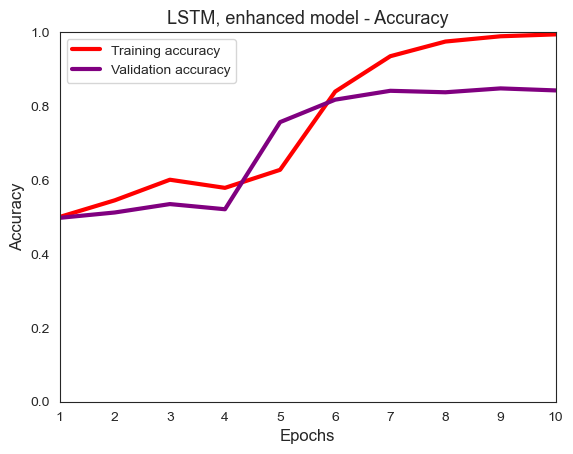

In [40]:
# Accuracy
sns.set_style('white')
sns.lineplot(x=range(1, len(his_lstm2.history['accuracy']) + 1), y = his_lstm2.history['accuracy'],
             label='Training accuracy', linewidth=3, color = 'red')
sns.lineplot(x=range(1, len(his_lstm2.history['val_accuracy']) + 1), y = his_lstm2.history['val_accuracy'],
             label='Validation accuracy', linewidth=3, color = 'purple')
plt.title("LSTM, enhanced model - Accuracy", fontsize=13)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.xlim(1, len(his_lstm2.history['accuracy']))
plt.ylim(0, 1)
plt.legend()
plt.show()

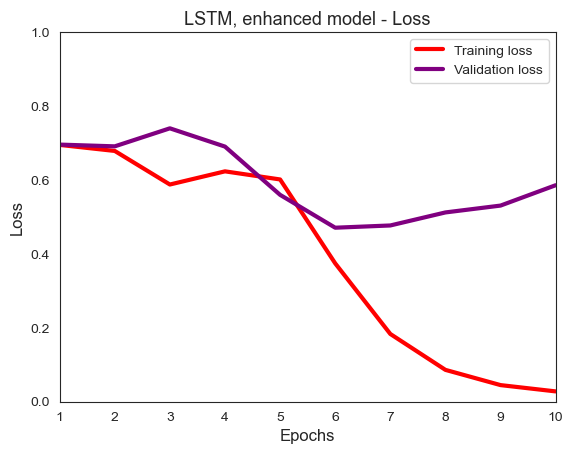

In [41]:
# Loss
sns.set_style('white')
sns.lineplot(x=range(1, len(his_lstm2.history['loss']) + 1), y = his_lstm2.history['loss'],
             label='Training loss', linewidth=3, color = 'red')
sns.lineplot(x=range(1, len(his_lstm2.history['val_loss']) + 1), y = his_lstm2.history['val_loss'],
             label='Validation loss', linewidth=3, color = 'purple')
plt.title("LSTM, enhanced model - Loss", fontsize=13)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.xlim(1, len(his_lstm2.history['loss']))
plt.ylim(0, 1)
plt.legend()
plt.show()

In [42]:
# Test performance
loss_lstm2, accuracy_lstm2 = lstm2.evaluate(X_test, y_test)
print(f'LSTM, enhanced model - Test Accuracy: {accuracy_lstm2:.4f}')

157/157 [==============================] - 68s 433ms/step - loss: 0.5980 - accuracy: 0.8410
LSTM, enhanced model - Test Accuracy: 0.8410


In [43]:
y_hat_test_lstm2 = lstm2.predict(X_test)
y_hat_test_lstm2 = (y_hat_test_lstm2 > 0.5).astype(int)

157/157 [==============================] - 69s 424ms/step


In [44]:
# Confusion matrix - test set
conf_mat_test2 = metrics.confusion_matrix(y_test, y_hat_test_lstm2)

Text(0.5, 269.55555555555554, 'Predicted labels')

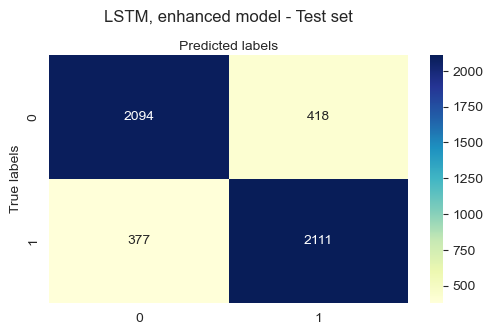

In [46]:
class_names=[0,1]
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Heatmap
sns.heatmap(pd.DataFrame(conf_mat_test2), annot = True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('LSTM, enhanced model - Test set', y=1.1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [45]:
# Other perfomance metrics
fpr_test2 = conf_mat_test2[0,1] / (conf_mat_test2[0,0] + conf_mat_test2[0,1])
fnr_test2 = conf_mat_test2[1,0] / (conf_mat_test2[1,0] + conf_mat_test2[1,1])


print(f'Accuracy: {metrics.accuracy_score(y_test, y_hat_test_lstm2) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_test2 * 100))
print("False negative rate: {:.2f}%".format(fnr_test2 * 100))
print(f'Precision: {metrics.precision_score(y_test, y_hat_test_lstm2) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_test, y_hat_test_lstm2) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_test, y_hat_test_lstm2, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - Test set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_test, y_hat_test_lstm2))

Accuracy: 84.10%
False positive rate: 16.64%
False negative rate: 15.15%
Precision: 83.47%
Sensivity (true positive rate) : 84.85%
Specificity (true negative rate): 83.36%




Classification report - Test set


              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2512
           1       0.83      0.85      0.84      2488

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



<font color = 'magenta' size='+2'><b> 3.3. Wider architecture and more regularization</b></font>

In [47]:
lstm3 = Sequential()
lstm3.add(Embedding(num_words, embedding_dim, input_length=max_seq_length))
lstm3.add(LSTM(units=300, return_sequences=True))
lstm3.add(Dropout(0.2))
lstm3.add(LSTM(units=150))
lstm3.add(Dropout(0.3))
lstm3.add(Dense(1, activation='sigmoid'))

In [48]:
optimizer_lstm3 = Adam(learning_rate=0.001)
lstm3.compile(optimizer = optimizer_lstm3, loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
his_lstm3 = lstm3.fit(X_train, y_train, epochs = 20, batch_size = batch_size, validation_split = 0.2)

Epoch 1/20
250/250 [==============================] - 673s 3s/step - loss: 0.6937 - accuracy: 0.5033 - val_loss: 0.6935 - val_accuracy: 0.5238
Epoch 2/20
250/250 [==============================] - 667s 3s/step - loss: 0.6747 - accuracy: 0.5532 - val_loss: 0.7320 - val_accuracy: 0.5217
Epoch 3/20
250/250 [==============================] - 661s 3s/step - loss: 0.6767 - accuracy: 0.5516 - val_loss: 0.6855 - val_accuracy: 0.5138
Epoch 4/20
250/250 [==============================] - 657s 3s/step - loss: 0.6667 - accuracy: 0.5479 - val_loss: 0.7020 - val_accuracy: 0.5077
Epoch 5/20
250/250 [==============================] - 661s 3s/step - loss: 0.6046 - accuracy: 0.5993 - val_loss: 0.6940 - val_accuracy: 0.5408
Epoch 6/20
250/250 [==============================] - 661s 3s/step - loss: 0.5333 - accuracy: 0.6999 - val_loss: 0.6306 - val_accuracy: 0.7500
Epoch 7/20
250/250 [==============================] - 660s 3s/step - loss: 0.4376 - accuracy: 0.8042 - val_loss: 0.5633 - val_accuracy: 0.7492

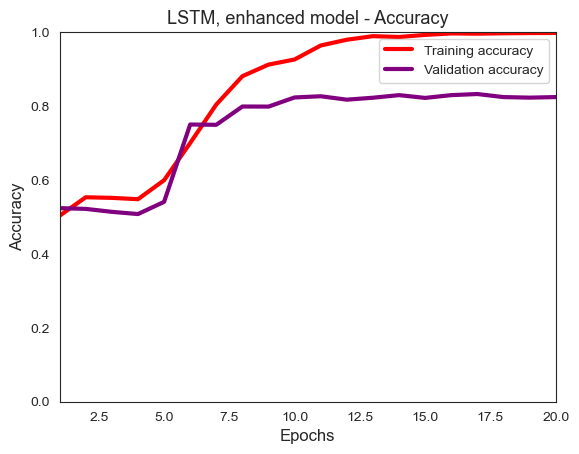

In [50]:
# Accuracy
sns.set_style('white')
sns.lineplot(x=range(1, len(his_lstm3.history['accuracy']) + 1), y = his_lstm3.history['accuracy'],
             label='Training accuracy', linewidth=3, color = 'red')
sns.lineplot(x=range(1, len(his_lstm3.history['val_accuracy']) + 1), y = his_lstm3.history['val_accuracy'],
             label='Validation accuracy', linewidth=3, color = 'purple')
plt.title("LSTM, enhanced model - Accuracy", fontsize=13)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.xlim(1, len(his_lstm3.history['accuracy']))
plt.ylim(0, 1)
plt.legend()
plt.show()

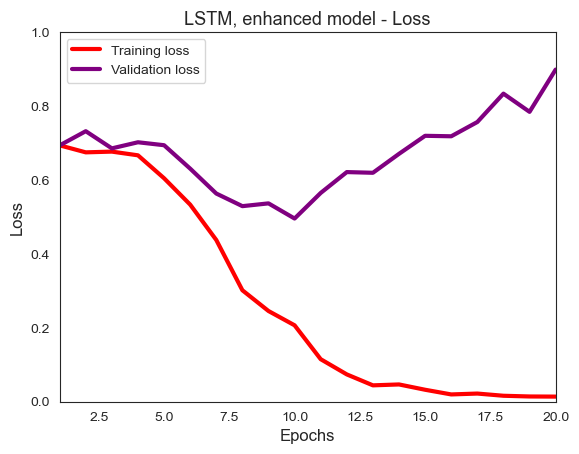

In [51]:
# Loss
sns.set_style('white')
sns.lineplot(x=range(1, len(his_lstm3.history['loss']) + 1), y = his_lstm3.history['loss'],
             label='Training loss', linewidth=3, color = 'red')
sns.lineplot(x=range(1, len(his_lstm3.history['val_loss']) + 1), y = his_lstm3.history['val_loss'],
             label='Validation loss', linewidth=3, color = 'purple')
plt.title("LSTM, enhanced model - Loss", fontsize=13)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.xlim(1, len(his_lstm3.history['loss']))
plt.ylim(0, 1)
plt.legend()
plt.show()

In [52]:
# Test performance
loss_lstm3, accuracy_lstm3 = lstm3.evaluate(X_test, y_test)
print(f'LSTM, enhanced model - Test Accuracy: {accuracy_lstm3:.4f}')

157/157 [==============================] - 64s 405ms/step - loss: 0.8767 - accuracy: 0.8276
LSTM, enhanced model - Test Accuracy: 0.8276


In [53]:
y_hat_test_lstm3 = lstm3.predict(X_test)
y_hat_test_lstm3 = (y_hat_test_lstm3 > 0.5).astype(int)

157/157 [==============================] - 62s 393ms/step


In [54]:
# Confusion matrix - test set
conf_mat_test3 = metrics.confusion_matrix(y_test, y_hat_test_lstm3)

Text(0.5, 269.55555555555554, 'Predicted labels')

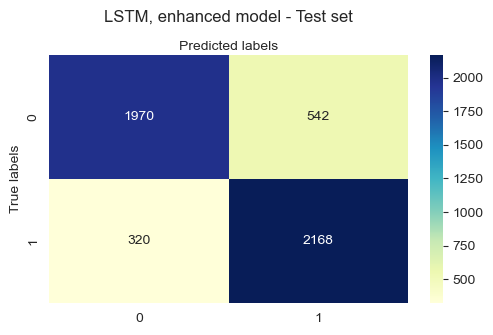

In [55]:
class_names=[0,1]
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Heatmap
sns.heatmap(pd.DataFrame(conf_mat_test3), annot = True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('LSTM, enhanced model - Test set', y=1.1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [56]:
# Other perfomance metrics
fpr_test3 = conf_mat_test3[0,1] / (conf_mat_test3[0,0] + conf_mat_test3[0,1])
fnr_test3 = conf_mat_test3[1,0] / (conf_mat_test3[1,0] + conf_mat_test3[1,1])


print(f'Accuracy: {metrics.accuracy_score(y_test, y_hat_test_lstm3) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_test3 * 100))
print("False negative rate: {:.2f}%".format(fnr_test3 * 100))
print(f'Precision: {metrics.precision_score(y_test, y_hat_test_lstm3) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_test, y_hat_test_lstm3) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_test, y_hat_test_lstm3, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - Test set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_test, y_hat_test_lstm3))

Accuracy: 82.76%
False positive rate: 21.58%
False negative rate: 12.86%
Precision: 80.00%
Sensivity (true positive rate) : 87.14%
Specificity (true negative rate): 78.42%




Classification report - Test set


              precision    recall  f1-score   support

           0       0.86      0.78      0.82      2512
           1       0.80      0.87      0.83      2488

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000

